# Environment

#### Hypatia
* virtual env: source envs/pSEOBNRv4HM_tgr_injections/bin/activate
* lalsuite: source $VIRTUAL_ENV/opt/lalsuite_pSEOBNRv4HM_tgr_injection/etc/lal*.sh

#### Laptop
* virtual env: pyenv activate pSEOBNRv4HM_tgr_injections
* lalsuite: source .pyenv/versions/pSEOBNRv4HM_tgr_injections/opt/lalsuite_pSEOBNRv4HM_tgr_injection_20201106_d16da559/etc/lalsuiterc 

In [32]:
#%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append('../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner
import glob
import h5py
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import rc
matplotlib.rc('text.latex', preamble = r'\usepackage{txfonts}')
rc_params = {'backend': 'ps',
             'axes.labelsize': 10,
             'axes.titlesize': 10,
             'font.size': 12,
             'legend.fontsize': 8,
             'xtick.labelsize': 13,
             'ytick.labelsize': 13,
             'font.family': 'Times New Roman'
             }

plt.rcParams.update(rc_params)
import json

### Functions

In [33]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=2.0)

# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR

# using fitting formulas from https://arxiv.org/pdf/gr-qc/0512160.pdf
# to get final mass and final spin from omega220 and tau220.
# See eqs.2.1, E1 and E2, and table VIII for fitting coefficients

def Mjfinal220(omega220,tau220):

    jf=1-pow((omega220*tau220/2.-0.7)/(1.4187),-1/0.4990)
    Mf=((1.5251 - 1.1568*pow((1 - jf),0.1292))/omega220)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)

    return Mf,jf

# 2D histogram
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    P_x = np.sum(P_xy, axis=0) * dy
    P_y = np.sum(P_xy, axis=1) * dx
    
    return P_xy, P_x, P_y, x_intp, y_intp, s1, s2

# Software Injections: GR/nonGR

In [34]:
# data

event_list = ['GW150914', 'GW190521']
run_list = ['0p0', '0p5', '0p0_GR', '0p5_GR']

data_dict = {}

for event in event_list:
    data_dict[event] = {}
    
    for run in run_list:
        
        data_loc = glob.glob('../runs/nonGR/%s-like/*_%s_widerdist/cbcBayes/posterior_samples.dat'%(event, run))[0]
        data_dict[event][run] = np.genfromtxt(data_loc, dtype=None, names=True)

## GW150914

[246.80589509] [4.13815066] [370.20884264] [6.20722599]


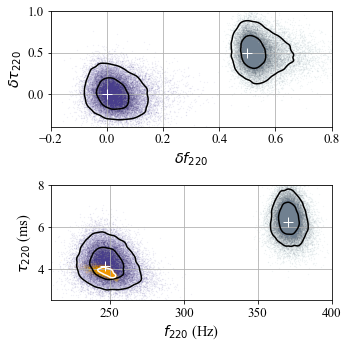

In [35]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 38.528614, 33.400536, 0.003469902, -0.04400404
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.
print(freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (color,run) in zip(['darkslateblue','slategrey'],['0p0', '0p5']):

    # read data
    data = data_dict['GW150914'][run]

    # read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
    m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
    
    # construct the frequencies and damping times
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    #ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color=color, alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color=color, alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# nGR: SEOBN$v4HM
data = data_dict['GW150914']['0p5_GR']

m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

# construct 2D histogram in omega220GR,tau220GR
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

#ax4.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Greys')
ax2.scatter(freq_modGR, tau_modGR, color='orange', alpha=0.1, s=0.1)
ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='w')

# plot GR predictions
ax1.plot(0,0,color='w',marker='+', ms=10)
ax1.plot(0.5,0.5,color='w',marker='+', ms=10)

ax2.plot(freq_GR_inj, tau_GR_inj,color='w',marker='+', ms=10)
ax2.plot(freq_modGR_inj, tau_modGR_inj,color='w',marker='+', ms=10)

ax1.set_xlabel("$\delta f_{220}$",fontsize='large')
ax1.set_ylabel(r"$\delta \tau_{220}$", fontsize='large')
ax2.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax2.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

ax1.set_xlim([-0.2,0.8])
ax1.set_ylim([-0.4,1.])

ax2.set_xlim([210,400])
ax2.set_ylim([2.5,8])

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/GW150914_simulated_signal_gr_ngr.png', dpi=300)
plt.savefig('../papers/intro_paper/figures/GW150914_simulated_signal_gr_ngr.pdf', dpi=300)

## GW190521

[62.85722555] [15.53250496] [94.28583832] [23.29875745]


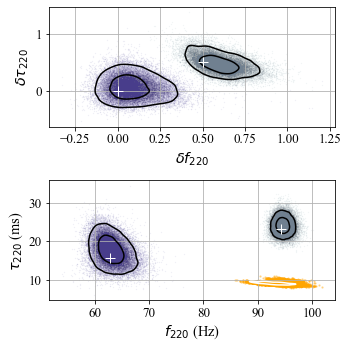

In [36]:
m1_inj, m2_inj, a1z_inj, a2z_inj = 152.599213, 120.400780, 0.02299293, -0.3864437
freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj = eff_quant(np.array([m1_inj]), \
                                                                   np.array([m2_inj]), \
                                                                   np.array([a1z_inj]), \
                                                                   np.array([a2z_inj]), \
                                                                   0.5, 0.5, [2,2])
tau_GR_inj *= 1000.
tau_modGR_inj *= 1000.
print(freq_GR_inj, tau_GR_inj, freq_modGR_inj, tau_modGR_inj)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (color,run) in zip(['darkslateblue','slategrey'],['0p0', '0p5']):

    # read data
    data = data_dict['GW190521'][run]

    # read out the specific columns: m1,m2,a1z,a2z,domega220,dtau220
    m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
    
    # construct the frequencies and damping times
    freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    #ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color=color, alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color=color, alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

# nGR: SEOBN$v4HM
data = data_dict['GW190521']['0p5_GR']

m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

# construct 2D histogram in omega220GR,tau220GR
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

#ax4.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Greys')
ax2.scatter(freq_modGR, tau_modGR, color='orange', alpha=0.3, s=2)
ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='w')

# plot GR predictions
ax1.plot(0,0,color='w',marker='+', ms=10)
ax1.plot(0.5,0.5,color='w',marker='+', ms=10)

ax2.plot(freq_GR_inj, tau_GR_inj,color='w',marker='+', ms=10)
ax2.plot(freq_modGR_inj, tau_modGR_inj,color='w',marker='+', ms=10)

ax1.set_xlabel("$\delta f_{220}$",fontsize='large')
ax1.set_ylabel(r"$\delta \tau_{220}$", fontsize='large')
ax2.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax2.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

#ax1.set_xlim([-0.2,0.8])
#ax1.set_ylim([-0.4,1.])

#ax2.set_xlim([210,400])
#ax2.set_ylim([2.5,8])

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/GW190521_simulated_signal_gr_ngr.png', dpi=300)
plt.savefig('../papers/intro_paper/figures/GW190521_simulated_signal_gr_ngr.pdf', dpi=300)

### Example corner plot

(27612, 6)


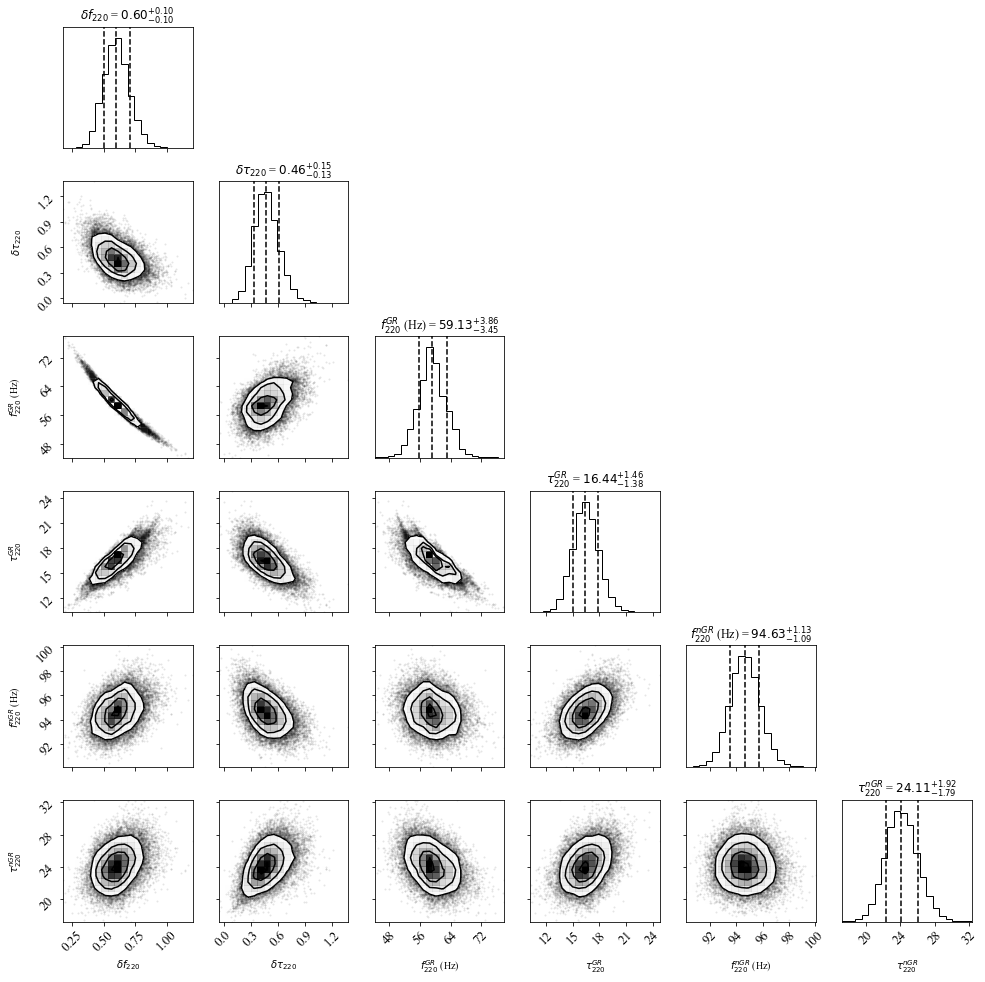

In [37]:
# nGR run for GW190521

data = data_dict['GW190521']['0p5']

m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], \
                                data["domega220"], data["dtau220"]

freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])

tau_GR *= 1000.
tau_modGR *= 1000.

data_corner = np.vstack([domega, dtau, freq_GR, tau_GR, freq_modGR, tau_modGR])
data_corner = data_corner.T
print(np.shape(data_corner))

figure = corner.corner(data_corner, labels=[r"$\delta f_{220}$", r"$\delta \tau_{220}$", \
                            r"$f^{GR}_{220}$ (Hz)", r"$\tau ^{GR}_{220}$", \
                           r"$f^{nGR}_{220}$ (Hz)", r"$\tau ^{nGR}_{220}$"],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})


plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/GW190521_simulated_signal_gr_corner.png', dpi=300)
plt.savefig('../papers/intro_paper/figures/GW190521_simulated_signal_gr_corner.pdf', dpi=300)

## Modified GR waveforms

In [38]:
waveform_data = {}

event_list = ['GW150914']
run_list = ['0p0', '0p5']
domain_list = ['time', 'freq']
det_list = ['H1', 'L1']

for event in event_list:
    waveform_data[event] = {}
    
    for run in run_list:
        waveform_data[event][run] = {}
        
        for domain in domain_list:
            waveform_data[event][run][domain] = {}
            
            for det in det_list:
                
                data = np.loadtxt("../runs/nonGR/%s-like/%s/%s_%sInjection.dat"%(event, run, det, domain))
                waveform_data[event][run][domain][det] = data
                
print(waveform_data)

{'GW150914': {'0p0': {'time': {'H1': array([[1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       ...,
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00]]), 'L1': array([[1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       [1.12628521e+09, 0.00000000e+00],
       ...,
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00],
       [1.12628522e+09, 0.00000000e+00]])}, 'freq': {'H1': array([[ 0.00000e+00, -4.26339e-25,  0.00000e+00],
       [ 2.50000e-01,  1.40475e-25,  4.05022e-25],
       [ 5.00000e-01,  3.37409e-25, -2.71146e-25],
       ...,
       [ 2.04750e+03,  3.91585e-27,  2.97025e-27],
       [ 2.04775e+03,  1.56785e-27, -4.65845e-27],
       [ 2.04800e+03, -4.91578e-27,  0.00000e+00]]), 'L1': array([[ 0.00000e+00,  5.42540e-25,  0.00000e+00],
       [ 2.50000e-01, -1.69114e-25, -5.17939

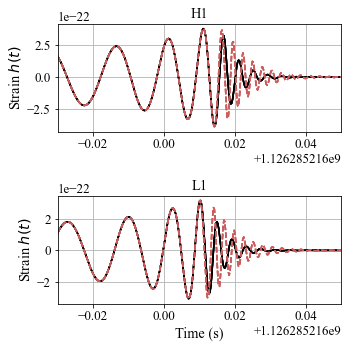

In [39]:
color_list = ['k', 'indianred']
ls_list = ['solid', 'dashed']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

t0 = 1126285216

for event in event_list:
    for (idx, run) in enumerate(run_list):
        for domain in domain_list:
            for det in det_list:
                
                ax1.plot(waveform_data[event][run]['time']['H1'][:,0], waveform_data[event][run]['time']['H1'][:,1], color=color_list[idx], ls=ls_list[idx])
                ax2.plot(waveform_data[event][run]['time']['L1'][:,0], waveform_data[event][run]['time']['L1'][:,1], color=color_list[idx], ls=ls_list[idx])
                
ax1.set_xlim([t0 - 0.03, t0 + 0.05]) 
ax2.set_xlim([t0 - 0.03, t0 + 0.05])  

ax1.set_ylabel('Strain $h(t)$', fontsize='large')
ax2.set_ylabel('Strain $h(t)$', fontsize='large')
ax2.set_xlabel('Time (s)', fontsize='large')

ax1.set_title('H1', fontsize='large')
ax2.set_title('L1', fontsize='large')

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/modGR_waveforms.png', dpi=300)
plt.savefig('../papers/intro_paper/figures/modGR_waveforms.pdf', dpi=300)

## No-hair test with SXS:BBH:0166

In [40]:
# data

post_loc_sxs_bbh_0166_220 = "../runs/parallel_bilby/GW150914_SXS_BBH_0166_220_v2_widerprior/outdir/GW150914_checkpoint_preresult.json"
with open(post_loc_sxs_bbh_0166_220, "r") as f:
    data_sxs_bbh_0166_220 = json.load(f)
    
post_loc_sxs_bbh_0166_330 = "../runs/parallel_bilby/GW150914_SXS_BBH_0166_330_v3_widerprior/outdir/GW150914_result.json"
with open(post_loc_sxs_bbh_0166_330, "r") as f:
    data_sxs_bbh_0166_330 = json.load(f)

[310.48288255 240.10290092 240.10290092 ... 141.48196149 141.48196149
 141.48196149] [0.01161727 0.00970398 0.00970398 ... 0.01199571 0.01199571 0.01199571]


/Users/abhirupghosh/.pyenv/versions/3.6.9/envs/pSEOBNRv4HM_tgr_injections/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/abhirupghosh/.pyenv/versions/3.6.9/envs/pSEOBNRv4HM_tgr_injections/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: No contour levels were found within the data range.
/Users/abhirupghosh/.pyenv/versions/3.6.9/envs/pSEOBNRv4HM_tgr_injections/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: No contour levels were found within the data range.


[786.92214773  55.335123   601.99855484 ... 141.1062336  141.1062336
 141.1062336 ] [0.00304112 0.00295376 0.00343951 ... 0.00710251 0.00710251 0.00710251]


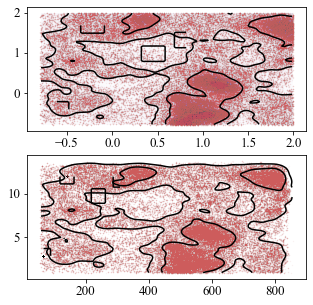

In [41]:
color_list = ['k', 'indianred']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (idx, data) in enumerate([data_sxs_bbh_0166_220, data_sxs_bbh_0166_330]):

    m1, m2, a1z, a2z = data['posterior']['content']['mass_1'], \
        data['posterior']['content']['mass_2'], \
        data['posterior']['content']['chi_1'], \
        data['posterior']['content']['chi_2']
    
    if data == data_sxs_bbh_0166_220:
        domega, dtau = data['posterior']['content']['domega220'], data['posterior']['content']['dtau220']
    
        m1, m2, a1z, a2z, domega, dtau = np.array(m1), np.array(m2), np.array(a1z), \
                                    np.array(a2z), np.array(domega), np.array(dtau)
    
        # construct the frequencies and damping times
        freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
        
    elif data == data_sxs_bbh_0166_330:
        domega, dtau = data['posterior']['content']['domega330'], data['posterior']['content']['dtau330']
    
        m1, m2, a1z, a2z, domega, dtau = np.array(m1), np.array(m2), np.array(a1z), \
                                    np.array(a2z), np.array(domega), np.array(dtau)
    
        # construct the frequencies and damping times
        freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [3,3])
        
    print(freq_modGR,tau_modGR)

    # converty damping time samples from second to milli-second
    tau_GR *= 1000.
    tau_modGR *= 1000.
    
    # construct 2D histogram in domega220,dtau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(domega, dtau, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram
    
    ax1.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax1.scatter(domega, dtau, color=color_list[idx], alpha=0.1, s=0.1)
    ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')
    
    # construct 2D histogram in omega220,tau220
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    #ax2.pcolormesh(x_intp, y_intp, gf(P_xy), cmap='Purples')
    ax2.scatter(freq_modGR, tau_modGR, color=color_list[idx], alpha=0.1, s=0.1)
    ax2.contour(x_intp, y_intp, gf(P_xy), levels=(s2,s1), colors='k')

## GW150914 real event

In [42]:
run_list = ['1sec', '3sec', '5sec', 'IMR', 'pEOB', 'pSEOB']
label_list = ['1 sec', '3 sec', '5 sec', 'IMR', 'pEOB', 'pSEOB']
loc_list = ['../data/GW150914/QNM_1ms.dat', '../data/GW150914/QNM_3ms.dat', \
            '../data/GW150914/QNM_5ms.dat', '../data/GW150914/QNM_IMR.dat', \
            '../data/GW150914/pEOB.dat', '../data/GW150914/pSEOB.dat']

data_GW150914 = {}

for (run, loc) in zip(run_list, loc_list):
    data_GW150914[run] = np.loadtxt(loc)
    
print(data_GW150914)    

{'1sec': array([[229.07659978,   5.27738284],
       [227.93419579,   4.71209329],
       [233.51180763,   4.99728145],
       ...,
       [226.54753972,   5.10915215],
       [233.80411091,   5.32780353],
       [232.72336227,   4.87781173]]), '3sec': array([[238.60689125,   3.5448927 ],
       [251.02541356,   3.63052908],
       [231.60718914,   3.99032607],
       ...,
       [242.95529085,   3.21969932],
       [238.67093292,   3.7883069 ],
       [233.23689328,   6.08984985]]), '5sec': array([[228.16807439,   2.80883937],
       [229.73477412,   2.07380555],
       [238.46444786,   2.3121308 ],
       ...,
       [235.11042423,   2.10030274],
       [219.48578122,   3.2567194 ],
       [246.94657723,   2.05918893]]), 'IMR': array([[250.91745325,   3.90731834],
       [247.5882996 ,   4.2817817 ],
       [252.36279766,   3.88382706],
       ...,
       [246.50341555,   4.05373101],
       [255.48974439,   3.83341075],
       [243.90300329,   4.02005876]]), 'pEOB': array([[253.2028

/Users/abhirupghosh/.pyenv/versions/3.6.9/envs/pSEOBNRv4HM_tgr_injections/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'labels'


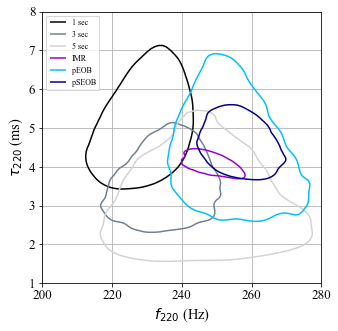

In [43]:
color_list = ['k', 'slategrey', 'lightgrey', 'darkviolet', 'deepskyblue', 'darkblue']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

for (idx, run) in enumerate(run_list):
    
    
    freq_modGR, tau_modGR = data_GW150914[run][:,0], data_GW150914[run][:,1]
    # construct 2D histogram in omega220GR,tau220GR
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(freq_modGR, tau_modGR, N_bins=100)
    
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors=color_list[idx], labels=run)
    CS.collections[0].set_label(label_list[idx])

    
    
ax1.legend(loc='upper left')
ax1.set_xlim([200, 280])     
ax1.set_ylim([1, 8])

ax1.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax1.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

ax1.grid()
plt.savefig('../papers/intro_paper/figures/GW150914.png', dpi=300)
plt.savefig('../papers/intro_paper/figures/GW150914.pdf', dpi=300)

# Noise Systematics

In [54]:
# load data

data_noise = {}

run_list = ['gaussian', 'realnoise', 'realevent']

for run in run_list:
    data_noise[run] = {}

    
# loading gaussian noise data    
gaussian_noise_list = ["noise01", "noise02", "noise03", "noise04", "noise05", "zeronoise"]

for gaussian_noise in gaussian_noise_list:
    data_noise['gaussian'][gaussian_noise] = np.genfromtxt('../runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_%s/pesummary/samples/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat'%gaussian_noise, unpack=True)
    
# loading real noise data
real_noise_list = ["1242454457", "1242456257", "1242458057", "1242461657", "1242463457"]

for real_noise in real_noise_list:
    data_noise['realnoise'][real_noise] = np.genfromtxt('../runs/review/21g_injections/NRSur7dq4_MaxL_EXP30_realnoise/%s/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat'%real_noise, unpack=True)

# loading data for actual event    
data_noise['realevent'] = np.genfromtxt('../runs/O3a/GW190521a/220_rererun_newpsd/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat', unpack=True)

print(data_noise)

{'gaussian': {'noise01': array([[6.03250593e+01, 6.01797804e+01, 6.98624975e+01, ...,
        6.58176904e+01, 6.58176904e+01, 6.58176904e+01],
       [1.64252239e-02, 2.05744923e-02, 1.61178720e-02, ...,
        8.59143838e-03, 8.59143838e-03, 8.59143838e-03]]), 'noise02': array([[6.88212155e+01, 7.05506278e+01, 6.65833153e+01, ...,
        6.81071557e+01, 6.75707505e+01, 6.75707505e+01],
       [1.72053792e-02, 1.75932474e-02, 3.38693484e-02, ...,
        1.69646401e-02, 1.73812771e-02, 1.73812771e-02]]), 'noise03': array([[6.93166695e+01, 6.96554759e+01, 7.13641099e+01, ...,
        6.66230199e+01, 6.66230199e+01, 6.66230199e+01],
       [2.19342171e-02, 1.54026395e-02, 1.40546525e-02, ...,
        1.10156519e-02, 1.10156519e-02, 1.10156519e-02]]), 'noise04': array([[6.55471510e+01, 7.10857977e+01, 6.01543889e+01, ...,
        6.72976398e+01, 6.72976398e+01, 6.72976398e+01],
       [1.86225298e-02, 1.90671964e-02, 2.44350349e-02, ...,
        1.72594504e-02, 1.72594504e-02, 1.7259450

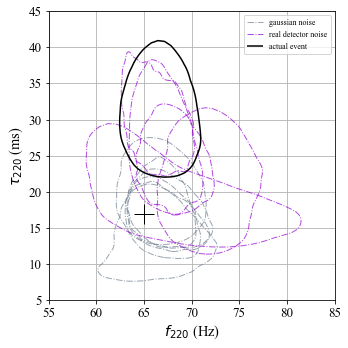

In [89]:
label_list = ['gaussian noise', 'real detector noise', 'actual event']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

for gaussian_noise in gaussian_noise_list:
    f, tau = data_noise['gaussian'][gaussian_noise][0,:], data_noise['gaussian'][gaussian_noise][1,:]
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, N_bins=100)
    
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    if gaussian_noise == gaussian_noise_list[0]:
        CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='slategrey', linewidths=1, linestyles='dashdot', alpha=0.7)
        CS.collections[0].set_label(label_list[0])
    else: 
        ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='slategrey', linewidths=1, linestyles='dashdot', alpha=0.7)
    
for real_noise in real_noise_list:
    f, tau = data_noise['realnoise'][real_noise][0,:], data_noise['realnoise'][real_noise][1,:]
    P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, N_bins=100)
    
    dx = np.mean(np.diff(x_intp))
    dy = np.mean(np.diff(y_intp))
    P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

    if real_noise == real_noise_list[0]:
        CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='darkviolet', linewidths=1, linestyles='dashdot', alpha=0.7)
        CS.collections[0].set_label(label_list[1])
    else: 
        ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='darkviolet', linewidths=1, linestyles='dashdot', alpha=0.7)
    
f, tau = data_noise['realevent'][0,:], data_noise['realevent'][1,:]
P_xy, P_x, P_y, x_intp, y_intp, s1, s2 = P_xy_2dhist(f, tau*1000, N_bins=100)

dx = np.mean(np.diff(x_intp))
dy = np.mean(np.diff(y_intp))
P_xy /= np.sum(P_xy) * dx * dy # normalise histogram

CS = ax1.contour(x_intp, y_intp, gf(P_xy), levels=(s2,), colors='k')
CS.collections[0].set_label(label_list[2])


# plot GR predictions
ax1.plot(65,17,color='k',marker='+', ms=20)

ax1.legend(loc='upper right')

ax1.set_xlabel("$f_{220}$ (Hz)", fontsize='large')
ax1.set_ylabel(r"$\tau_{220}$ (ms)", fontsize='large') 

ax1.set_xlim([55, 85])
ax1.set_ylim([5, 45])

ax1.grid()

plt.tight_layout()
plt.savefig('../papers/intro_paper/figures/S190521g_swinjs.png', dpi=300)
plt.savefig('../papers/intro_paper/figures/S190521g_swinjs.pdf', dpi=300)  